# Predicting Sequential Data With an LSTM

[<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/LSTM_Cell.svg/2880px-LSTM_Cell.svg.png">](LSTM)
<br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

from tqdm.notebook import trange, tqdm
from Dataset import WeatherDataset

In [2]:
# Path to the CSV file containing the weather dataset
dataset_file = "/home/prakunjpratapsingh/deeplearning/dlpplayground/weather.csv"

# Define the date to split the dataset into training and testing sets
split_date = pd.to_datetime('2023-01-01')

# Number of days in the input sequence
day_range = 30

# Number of days the MLP will take as input
days_in = 14

# Ensure that the total number of days in the input sequence is larger than the MLP input size
assert day_range > days_in, "The total day range must be larger than the input days for the MLP"

# Define the hyperparameters for training the model
learning_rate = 1e-4  # Learning rate for the optimizer
nepochs = 500  # Number of training epochs
batch_size = 32  # Batch size for training

# Create training dataset
# This will load the weather data, consider sequences of length day_range,
# and split the data such that data before split_date is used for training
dataset_train = WeatherDataset(dataset_file, day_range=day_range, split_date=split_date, train_test="train")

# Create testing dataset
# This will load the weather data, consider sequences of length day_range,
# and split the data such that data after split_date is used for testing
dataset_test = WeatherDataset(dataset_file, day_range=day_range, split_date=split_date, train_test="test")

In [3]:
print(f'Number of training examples: {len(dataset_train)}')
print(f'Number of testing examples: {len(dataset_test)}')

Number of training examples: 3465
Number of testing examples: 397


In [4]:
data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
data_loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, drop_last=True)

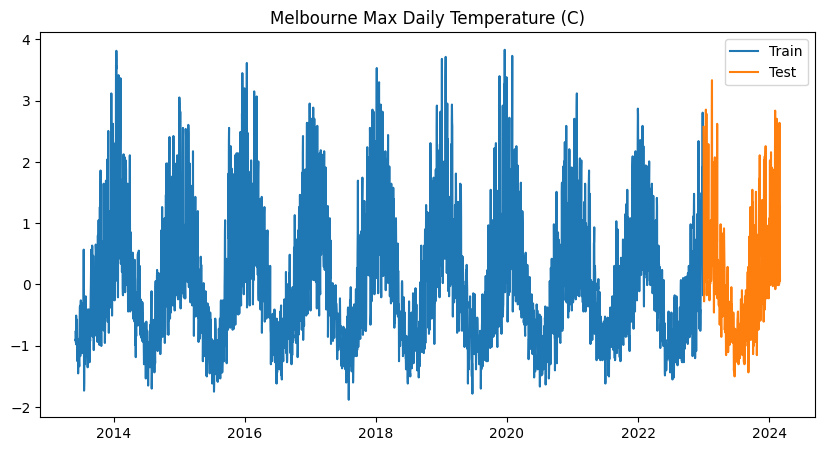

In [5]:
fig = plt.figure(figsize=(10, 5))
_ = plt.title("Melbourne Max Daily Temperature (C)")

_ = plt.plot(dataset_train.dataset.index, dataset_train.dataset.values[:, 1])
_ = plt.plot(dataset_test.dataset.index, dataset_test.dataset.values[:, 1])

_ = plt.legend(["Train", "Test"])
# Note:see here how we can just directly access the data from the dataset class

## Create LSTM Model
This is a network class definition that utilizes an LSTM (Long Short-Term Memory) architecture for sequential data prediction

In [6]:
class ResBlockMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResBlockMLP, self).__init__()
        # Define the layers for the residual block
        self.norm1 = nn.LayerNorm(input_size)
        self.fc1 = nn.Linear(input_size, input_size // 2)
        
        self.norm2 = nn.LayerNorm(input_size // 2)
        self.fc2 = nn.Linear(input_size // 2, output_size)
        
        self.fc3 = nn.Linear(input_size, output_size)

        self.act = nn.ELU()

    def forward(self, x):
        # Forward pass of the residual block
        x = self.act(self.norm1(x))
        skip = self.fc3(x)
        
        x = self.act(self.norm2(self.fc1(x)))
        x = self.fc2(x)
        
        return x + skip


class LSTM(nn.Module):
    def __init__(self, seq_len, output_size, num_blocks=1):
        super(LSTM, self).__init__()
        # Calculate the length of the sequence data
        seq_data_len = seq_len * 2
        # Define the layers for the input MLP
        self.input_mlp = nn.Sequential(nn.Linear(seq_data_len, 4 * seq_data_len),
                                       nn.ELU(),
                                       nn.Linear(4 * seq_data_len, 128))
        # Create an LSTM block
        self.lstm = nn.LSTM(input_size=128, hidden_size=128, num_layers=1)
        
        # Define residual blocks
        blocks = [ResBlockMLP(128, 128) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*blocks)
        
        # Output fully connected layer
        self.fc_out = nn.Linear(128, output_size)
        self.act = nn.ELU()

    def forward(self, input_seq, hidden_in, mem_in):
        # Reshape input sequence
        input_seq = input_seq.reshape(input_seq.shape[0], -1)
        
        # Pass input sequence through the input MLP
        input_vec = self.input_mlp(input_seq).unsqueeze(0)
        
        # Pass input through LSTM block
        output, (hidden_out, mem_out) = self.lstm(input_vec, (hidden_in, mem_in))
        
        # Pass LSTM output through residual blocks
        x = self.act(self.res_blocks(output)).squeeze(0)
        
        # Pass through output fully connected layer
        return self.fc_out(x), hidden_out, mem_out

##  Initialize LSTM and Optimizer

In [7]:
# Set the device to GPU if available, otherwise fallback to CPU
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

# Create the LSTM model
weather_lstm = LSTM(seq_len=days_in, output_size=2).to(device)

# Initialize the optimizer with the specified learning rate and model parameters
optimizer = optim.Adam(weather_lstm.parameters(), lr=learning_rate)

# Define the loss function (mean squared error)
loss_fn = nn.MSELoss()

# Initialize an empty list to log training loss
training_loss_logger = []

## Training
Lets train our LSTM model (weather_lstm) using the data loader (data_loader_train)

In [9]:
for epoch in trange(nepochs, desc="Epochs", leave=False):
    # Set the model to training mode
    weather_lstm.train()
    
    # Iterate over batches in the training data loader
    for day, month, data_seq in tqdm(data_loader_train, desc="Training", leave=False):
        # Extract input sequence block
        seq_block = data_seq[:, :days_in].to(device)
        
        # Initialize hidden state and memory tensors with zeros
        hidden = torch.zeros(1, data_seq.shape[0], 128, device=device)
        memory = torch.zeros(1, data_seq.shape[0], 128, device=device)

        # Initialize loss value
        loss = 0
        
        # Iterate over the sequence steps
        for i in range(day_range - days_in):
            # Extract target sequence block
            target_seq_block = data_seq[:, i + days_in].to(device)
            
            # Forward pass: predict using the input sequence block and update hidden states
            data_pred, hidden, memory = weather_lstm(seq_block, hidden, memory)
            
            # Accumulate the loss
            loss += loss_fn(data_pred, target_seq_block)

            # Update input sequence block by removing the oldest prediction and adding the new prediction
            seq_block = torch.cat((seq_block[:, 1:, :], data_pred.unsqueeze(1).detach()), 1)
        
        # Calculate the average loss
        loss /= i + 1
        
        # Backpropagation: compute gradients and update model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Log the training loss
        training_loss_logger.append(loss.item())

Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

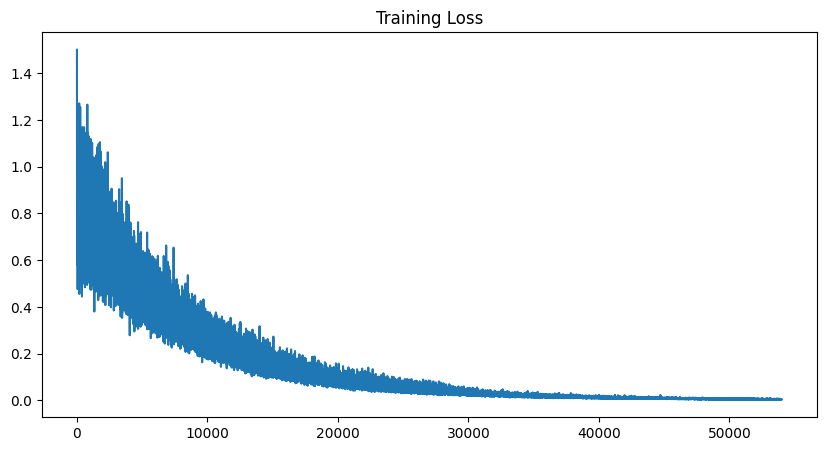

In [10]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(training_loss_logger)
_ = plt.title("Training Loss")

## Testing

In [11]:
data_tensor = torch.FloatTensor(dataset_test.dataset.values)

log_predictions = []  # List to store predicted weather values
weather_lstm.eval()  # Set the model to evaluation mode

with torch.no_grad():
    seq_block = data_tensor[:days_in, :].unsqueeze(0).to(device)  # Extract initial sequence block
    
    # Initialize hidden state and memory tensors with zeros
    hidden = torch.zeros(1, seq_block.shape[0], 128, device=device)
    memory = torch.zeros(1, seq_block.shape[0], 128, device=device)
    
    # Iterate over the remaining days in the test dataset
    for i in range(data_tensor.shape[0] - days_in):
        # Predict the next day's weather using the LSTM model
        data_pred, hidden, memory = weather_lstm(seq_block, hidden, memory)
        
        # Update the input sequence block by removing the oldest prediction and adding the new prediction
        seq_block = torch.cat((seq_block[:, 1:, :], data_pred.unsqueeze(1)), 1)
        
        # Append the predicted weather values to the list
        log_predictions.append(data_pred.cpu())

# Concatenate all predicted weather values
predictions_cat = torch.cat(log_predictions)

# Convert the predictions back to the original scale (undo normalization)
un_norm_predictions = (predictions_cat * dataset_test.std) + dataset_test.mean

# Convert the original test data back to the original scale
un_norm_data = (data_tensor * dataset_test.std) + dataset_test.mean

# Skip the initial days (as they were used for initialization) and keep the ground truth data
un_norm_data = un_norm_data[days_in:]

In [12]:
test_mse = (un_norm_data - un_norm_predictions).pow(2).mean().item()
print("Test MSE value %.2f" % test_mse)

Test MSE value 40.16


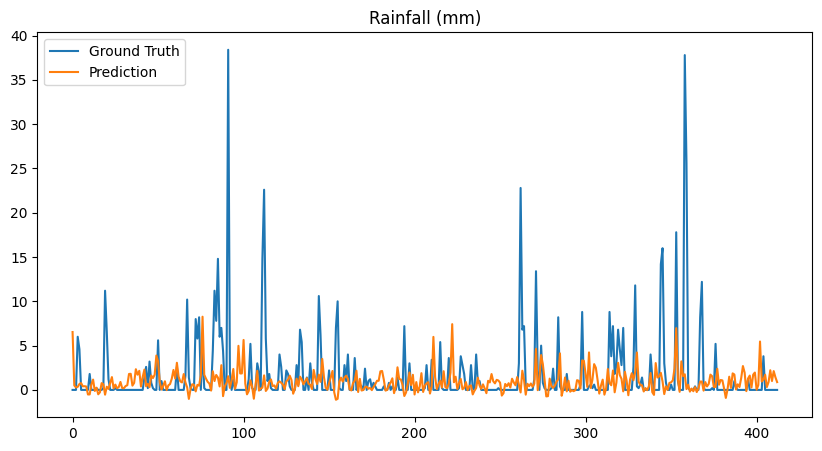

In [13]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(un_norm_data[:, 0])
_ = plt.plot(un_norm_predictions[:, 0])
_ = plt.title("Rainfall (mm)")

_ = plt.legend(["Ground Truth", "Prediction"])

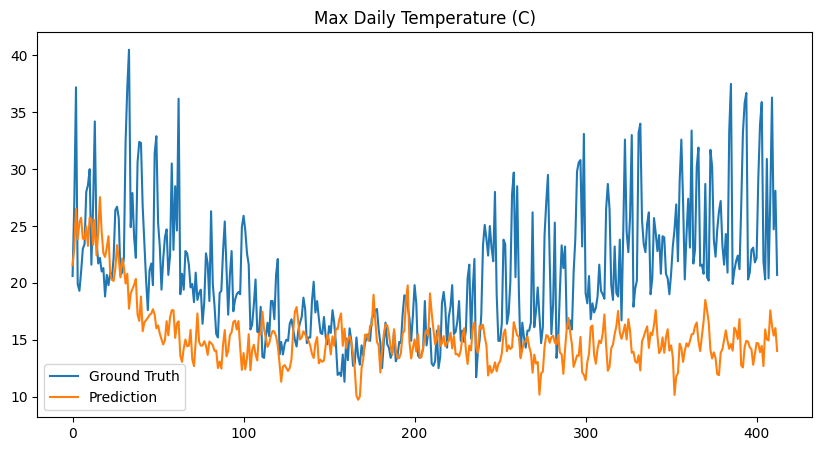

In [14]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(un_norm_data[:, 1])
_ = plt.plot(un_norm_predictions[:, 1])
_ = plt.title("Max Daily Temperature (C)")

_ = plt.legend(["Ground Truth", "Prediction"])